# Bike Sharing Demand
**Forecast use of a city bikeshare system**

# 1. EDA

In [23]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Import dataset
df_train = pd.read_csv("data/train.csv", index_col="datetime", parse_dates=True)
df_test = pd.read_csv("data/test.csv", index_col="datetime", parse_dates=True)
df = pd.concat([df_train, df_test], sort=True)
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print("Full shape:", df.shape)
df_train.head()

Train shape: (10886, 11)
Test shape: (6493, 8)
Full shape: (17379, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Data Description**:
- *datetime*: hourly date + timestamp
- *season*:
    - 1 = spring
    - 2 = summer
    - 3 = fall
    - 4 = winter
- *holiday*: wheter the day is considered a holiday
- *workingday*: whether the day is neither a weekend nor holiday
- *weather*: 
    - 1 = Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2 = Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3 = Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4 = Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- *temp*: temperature in Celsius
- *atemp*: "feels like" temperature in Celsius
- *humidity*: relative humidity
- *windspeed*: wind speed
- *casual*: number of non-registered user rentals initiated
- *registered*: number of registered user rentals initiated
- *count*: number of total rentals

In [3]:
# Let's check for descriptive statistics
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   atemp       17379 non-null  float64
 1   casual      10886 non-null  float64
 2   count       10886 non-null  float64
 3   holiday     17379 non-null  int64  
 4   humidity    17379 non-null  int64  
 5   registered  10886 non-null  float64
 6   season      17379 non-null  int64  
 7   temp        17379 non-null  float64
 8   weather     17379 non-null  int64  
 9   windspeed   17379 non-null  float64
 10  workingday  17379 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 1.6 MB


There are no missing values

In [4]:
df.describe()

,atemp,casual,count,holiday,humidity,registered,season,temp,weather,windspeed,workingday
count,17379.000000,10886.000000,10886.000000,17379.000000,17379.000000,10886.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,23.788755,36.021955,191.574132,0.028770,62.722884,155.552177,2.501640,20.376474,1.425283,12.736540,0.682721
std,8.592511,49.960477,181.144454,0.167165,19.292983,151.039033,1.106918,7.894801,0.639357,8.196795,0.465431
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.820000,1.000000,0.000000,0.000000
25%,16.665000,4.000000,42.000000,0.000000,48.000000,36.000000,2.000000,13.940000,1.000000,7.001500,0.000000
50%,24.240000,17.000000,145.000000,0.000000,63.000000,118.000000,3.000000,20.500000,1.000000,12.998000,1.000000
75%,31.060000,49.000000,284.000000,0.000000,78.000000,222.000000,3.000000,27.060000,2.000000,16.997900,1.000000
max,50.000000,367.000000,977.000000,1.000000,100.000000,886.000000,4.000000,41.000000,4.000000,56.996900,1.000000


The numbers look reasonable, no need to check for outliers or remove possibly wrong data

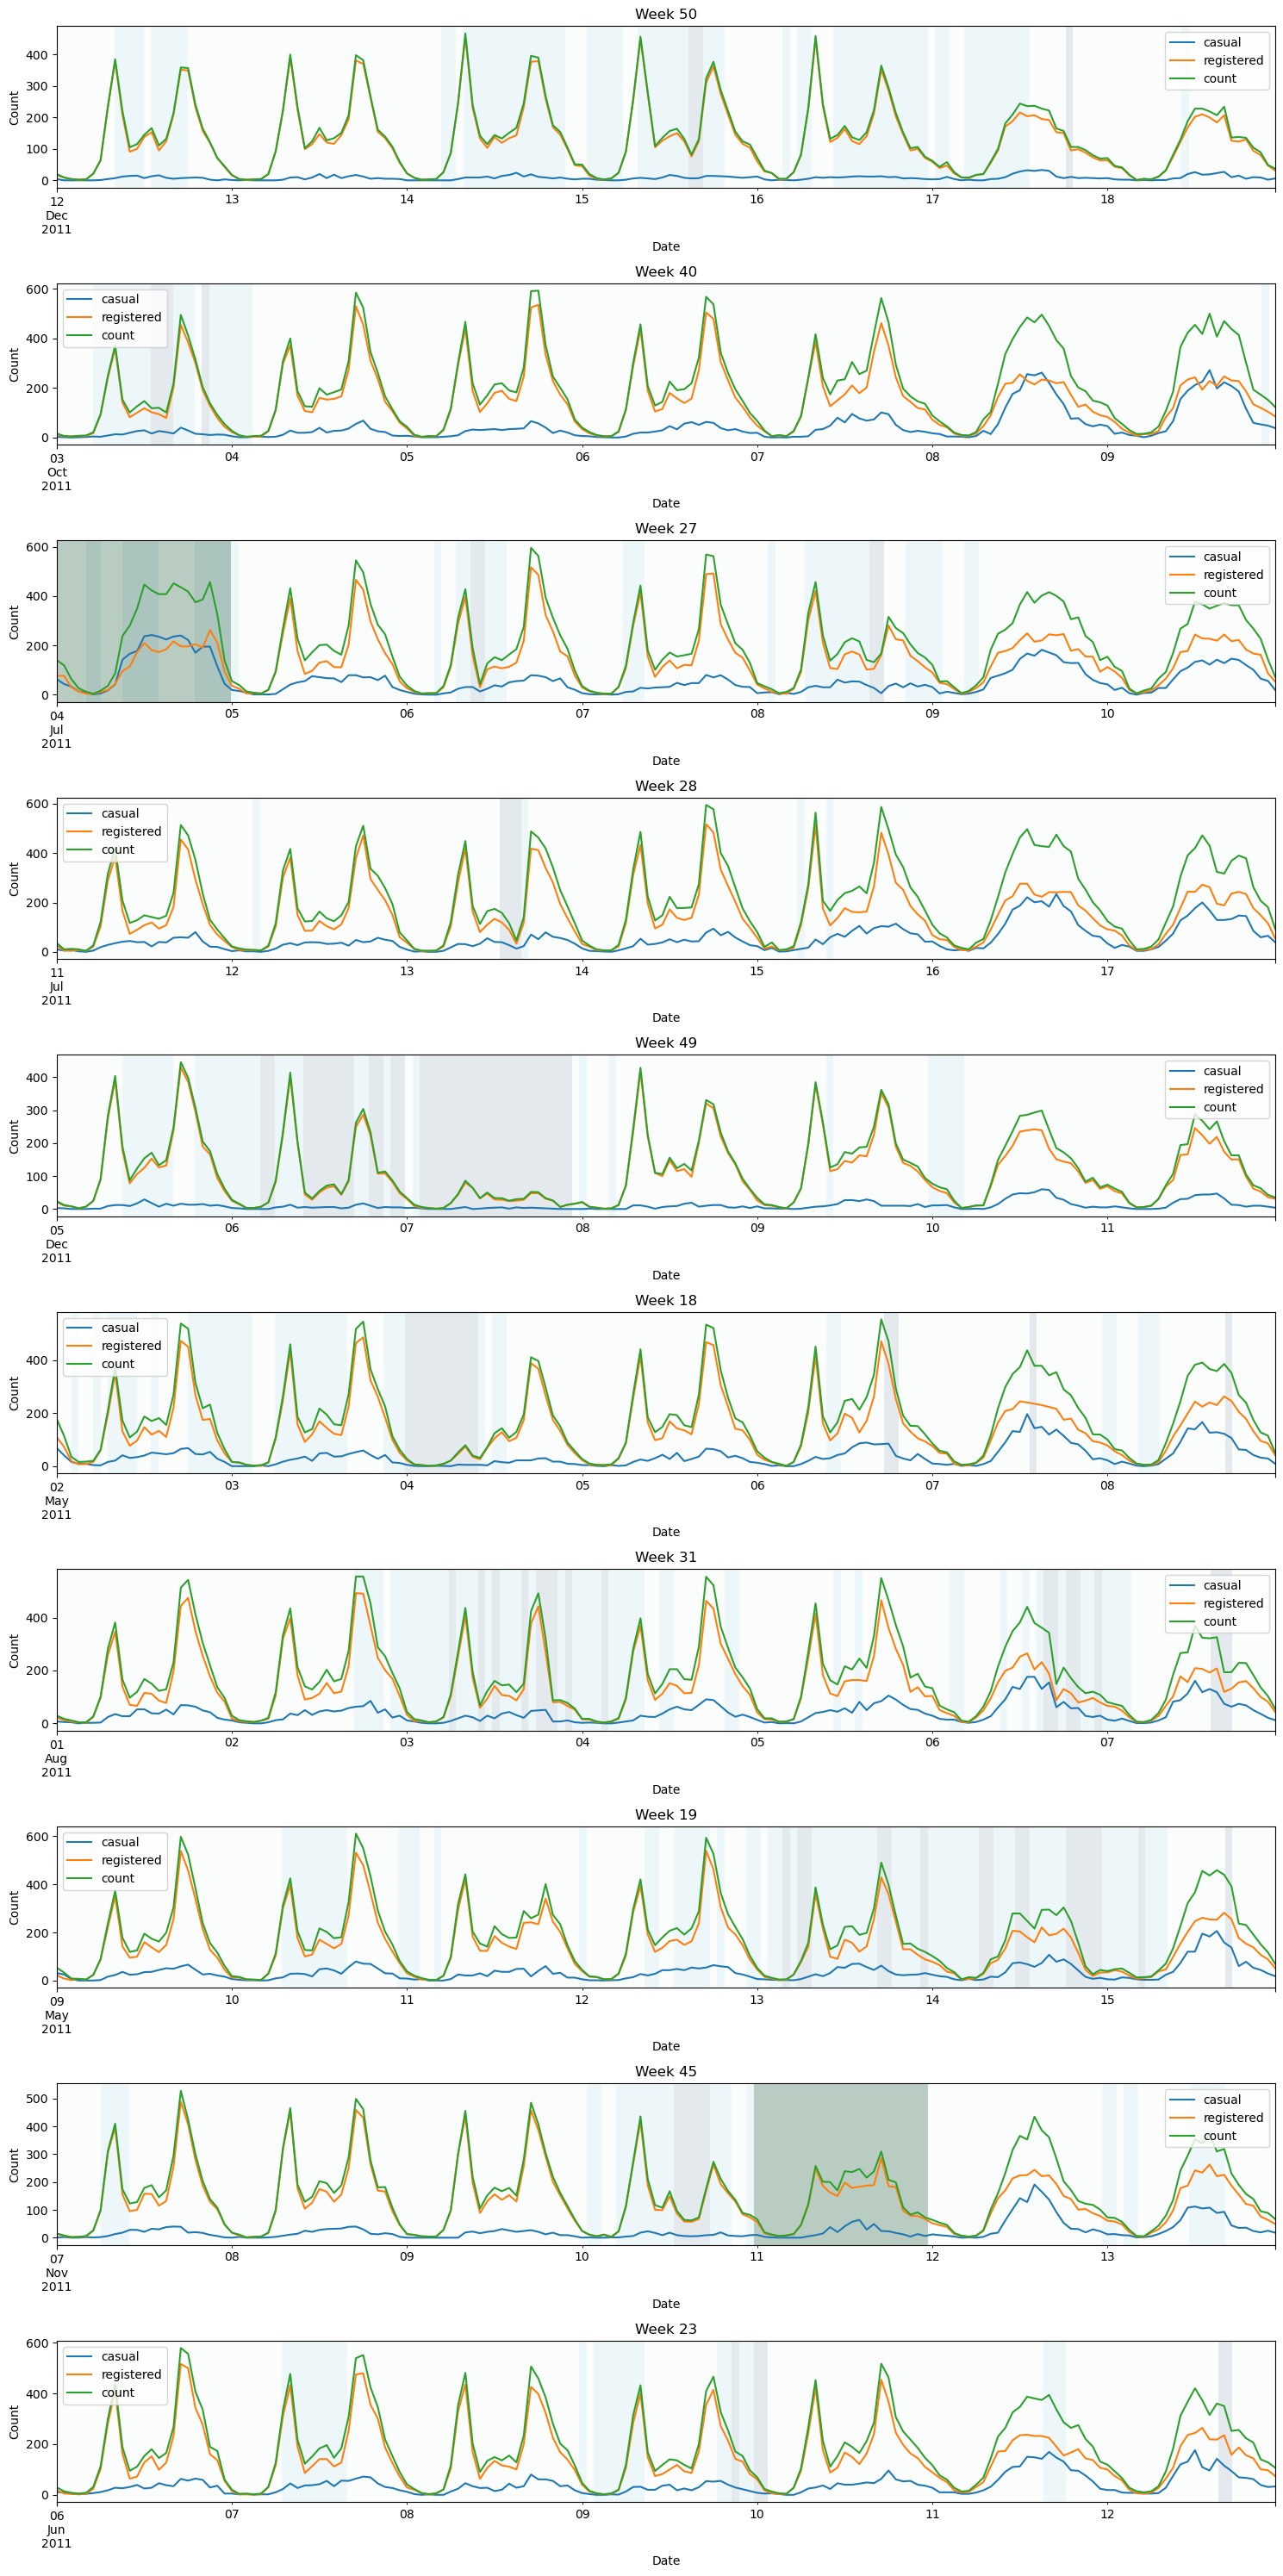

In [5]:
# Let's plot registered, casual and count for some sampled weeks

# Add week of year column
tmp = df_train.copy()
tmp["year"] = tmp.index.isocalendar().year
tmp["weekofyear"] = tmp.index.isocalendar().week
nweeks = 30
np.random.seed(38)
weeks = np.random.choice(tmp[tmp["year"] == 2011]["weekofyear"].unique(), replace=False, size=nweeks)

# Get dfs for plotting
dfs = []
for i, w in enumerate(weeks):
    cond = (tmp["year"] == 2011) & (tmp["weekofyear"] == w)
    if tmp[cond].shape[0] < 7 * 24:
        continue
    else:
        dfs.append(tmp[cond])

# Loop over weeks
fig, axes = plt.subplots(len(dfs), 1, figsize=(15, 30))
axes = axes.flatten()    
for i, dataframe in enumerate(dfs):
    w = dataframe["weekofyear"].unique()[0]
    dataframe[["casual", "registered", "count"]].plot(ax=axes[i], title=f"Week {w}")
    # Add color background to identify holidays
    axes[i].pcolorfast(axes[i].get_xlim(), axes[i].get_ylim(), dataframe[['holiday']].T.values, cmap="Greens", alpha=0.3)
    # Add color background to check weather
    axes[i].pcolorfast(axes[i].get_xlim(), axes[i].get_ylim(), dataframe[['weather']].T.values, cmap="Blues", alpha=0.1)
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Count")
plt.tight_layout()    
plt.show()

Few comments on the plots above:
- There are two seasonality in the data: a daily and a weekly seasonality. Day after day the pattern repeats and weekends show a
different behaviour compared to working days.
- During the week, the count is given mostly by the registered users. Casual users increase in the weekends.
- Holidays show a different pattern that resembles the weekends' one.
- Weather seems to influence the count pattern. To severe weather (week 49) corresponds a drop in count. In general, when the weather is not good, a reduction in the number of count is observed.
- It is not clear how much season influences count, we will try to determine this better looking at correlation or dedicated plots.
- It seems that in December, the number of casual users drops.

Let's dig more into the data by plotting distributions.

Could not plot column weather, value 4. Exception: `dataset` input should have multiple elements.


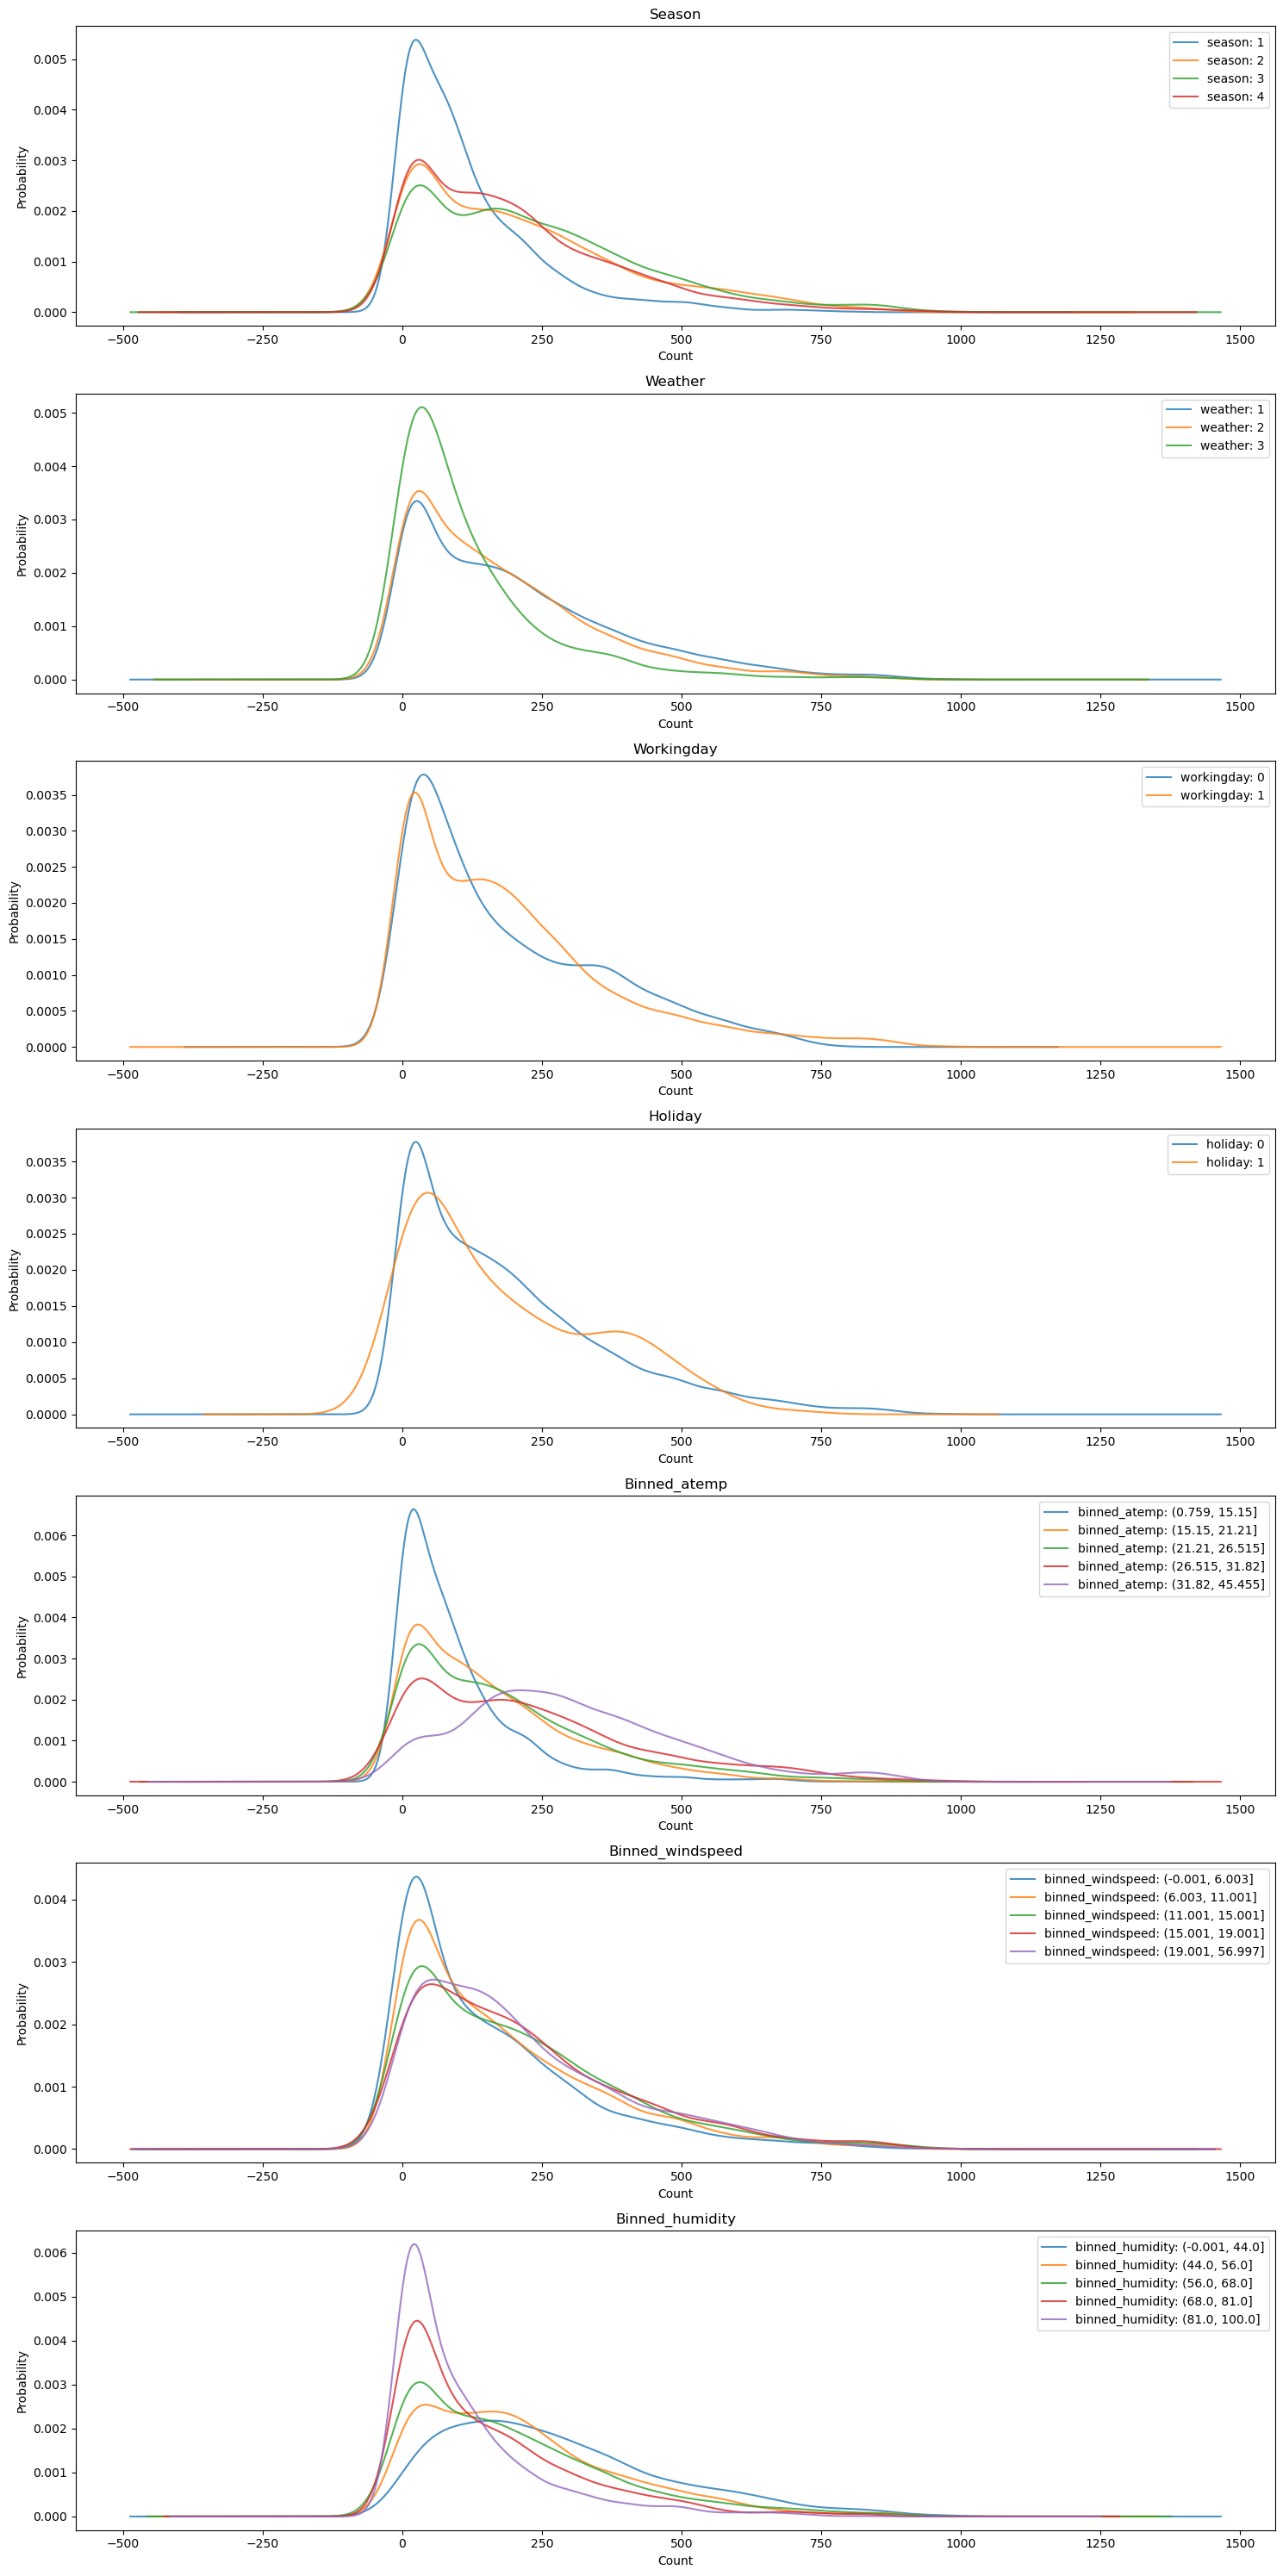

In [8]:
# Distributions
# count per season
# count per weather
# count per workingday
# count per holiday
# count per binned atemp
# count per binned windspeed
# count per binned humidity

# Make tmp df
tmp = df_train.copy()

# Add bin columns
tmp["binned_atemp"] = pd.qcut(x=tmp["atemp"], q=5)
tmp["binned_windspeed"] = pd.qcut(x=tmp["windspeed"], q=5)
tmp["binned_humidity"] = pd.qcut(x=tmp["humidity"], q=5)

# Add week of year column
cols = ["season", "weather", "workingday", "holiday", "binned_atemp", "binned_windspeed", "binned_humidity"]
fig, axes = plt.subplots(len(cols), 1, figsize=(15,30))
axes = axes.flatten()
for i, c in enumerate(cols):
    for uv in tmp[c].sort_values(ascending=True).unique():
        # weights = np.ones(len(df_train[df_train[c] == uv])) / len(df_train[df_train[c] == uv])
        # df_train[df_train[c] == uv]["count"].plot.hist(ax=axes[i], alpha=0.3, weights=weights, bins=20, label=f"{c}: {uv}")
        try:
            tmp[tmp[c] == uv]["count"].plot.kde(ax=axes[i], alpha=0.8, label=f"{c}: {uv}")
        except Exception as e:
            print(f"Could not plot column {c}, value {uv}. Exception: {e}")
        axes[i].set_title(c.capitalize())
        axes[i].set_ylabel("Probability")
        axes[i].set_xlabel("Count")
        axes[i].legend(loc=1)
plt.tight_layout()
plt.show()

Comments on the distributions above:
- season 1 shows a different distribution compared to the other seasons, answering to previous doubts we had in this regard.
- to severe weather corresponds a drop in count.
- working days and weekends show different distributions.
- holidays show a different distribution than other days. In particular there is a bump around count in the range 400-450.
- when the perceived temperature is low, there is a drop in count. Conversely, at high temperatures correspond an increase in count.
- to low windspeed corresponds a lower number of count. This is counterintuitive, maybe it is linked to how the wind change during the day. For instance, its speed might be higher in the afternoon when people usually rent bikes and slow down at night when no one is using the bike sharing system.
- Looking at humidity distributions, things become intuitive again with a drop in count when the humidity is high.

Let's plot also the distributions of *registered* and *casual* split per workingday and holiday. 

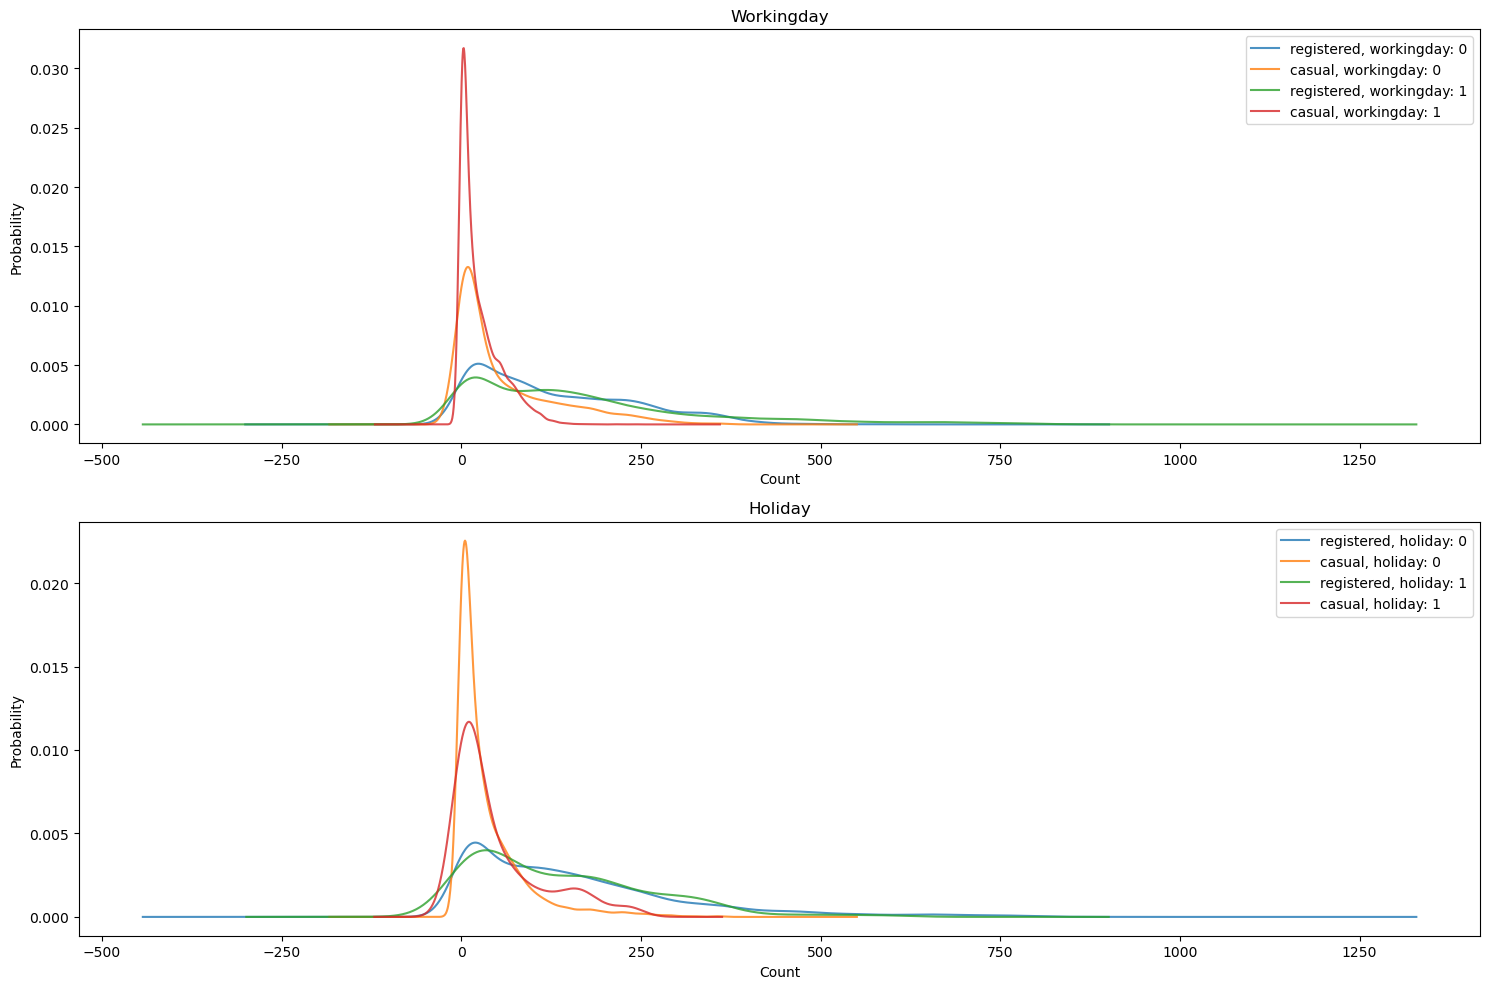

In [10]:
# Distributions
# registered and casual per workingday
# registered and casual per holiday

# Make tmp df
tmp = df_train.copy()

# Add week of year column
cols = ["workingday", "holiday"]
fig, axes = plt.subplots(len(cols), 1, figsize=(15, 10))
axes = axes.flatten()
for i, c in enumerate(cols):
    for uv in tmp[c].sort_values(ascending=True).unique():
        tmp[tmp[c] == uv]["registered"].plot.kde(ax=axes[i], alpha=0.8, label=f"registered, {c}: {uv}")
        tmp[tmp[c] == uv]["casual"].plot.kde(ax=axes[i], alpha=0.8, label=f"casual, {c}: {uv}")
        axes[i].set_title(c.capitalize())
        axes[i].set_ylabel("Probability")
        axes[i].set_xlabel("Count")
        axes[i].legend(loc=1)
plt.tight_layout()
plt.show()

While the distributions of *registered* do not change much from workingday = 0, holiday = 0 to workingday = 1, holiday = 1, the same does not hold for *casual* that exhibits a different behaviour. 

Let's now study the correlation among the features and the target.

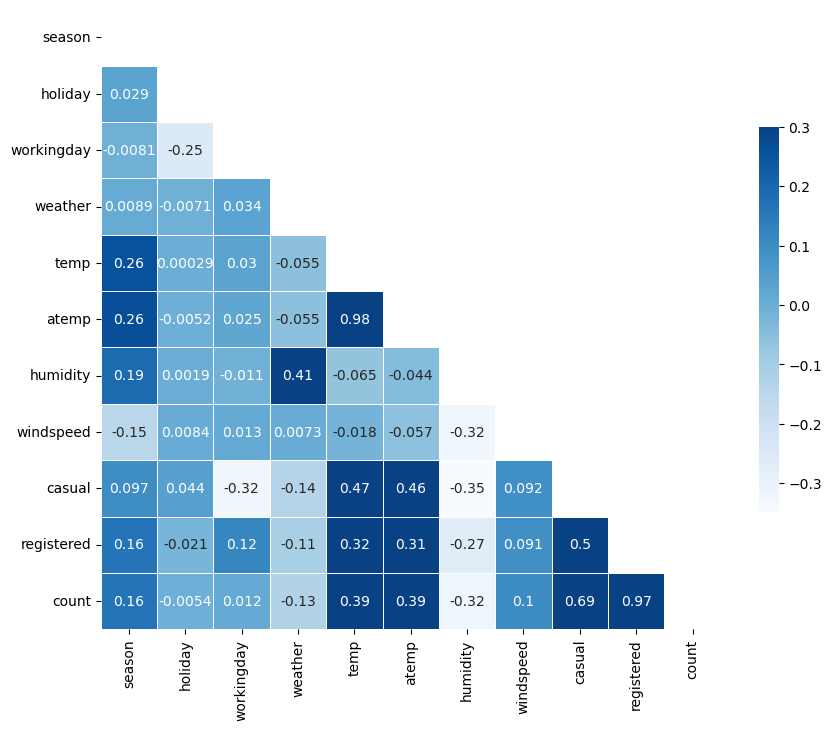

In [12]:
# Make copy of df train
tmp = df_train.copy()

# Compute the correlation matrix
corr = tmp.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3, center=0, cmap="Blues", annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Few comments about the plot above:
- season is correlated with weather data (which is expected), but shows also a correlation with count and registered. This reflects the behaviour of the distributions we saw before.
- holiday anti-correlates with workingday
- workingday anti-correlates with casual. This is in agreement with the distribution plots.
- weather correlates with humidity (when it rains humidity increases) and anti-correlates with casual, registered and count.
- temp and atemp has an extremely high correlation. This suggests we can get rid of temp and keeps only atemp.
- atemp correlates with the target. This is also something we already knew from the distribution.
- humidity anti-correlates with the target and windspeed
- causal is of course related with count and registered (indeed count = registered + casual)
- registered highly correlates with count. This is something we already knew from the time-series plots but it is remarkable: in most cases registered will be the main driver for determining count. However, for holidays, when there is severe weather, during the weekends etc... we will need the other features as well.

## 2. Feature Engineering

In [16]:
#  Let's remember how our dataset looks like
df.head()

,atemp,casual,count,holiday,humidity,registered,season,temp,weather,windspeed,workingday
datetime,,,,,,,,,,,
2011-01-01 00:00:00,14.395,3.0,16.0,0,81,13.0,1,9.84,1,0.0,0
2011-01-01 01:00:00,13.635,8.0,40.0,0,80,32.0,1,9.02,1,0.0,0
2011-01-01 02:00:00,13.635,5.0,32.0,0,80,27.0,1,9.02,1,0.0,0
2011-01-01 03:00:00,14.395,3.0,13.0,0,75,10.0,1,9.84,1,0.0,0
2011-01-01 04:00:00,14.395,0.0,1.0,0,75,1.0,1,9.84,1,0.0,0


Possible features that might improve model ability to predict the target are:
- hour_of_day
- is_weekday
- is_weekend
- day_of_week
- month
- casual, registerd and count lags (i.e. daily lag, weekly lag plus some autoregressive lags)
- casual, registerd and count lagged moving averages
- binned_atemp, binned_humidity, binned_windspeed

After adding the above, we can drop workingday, temp, atemp, humidity and windspeed.

In [22]:
# Let's start from time index features
df["hour_of_day"] = df.index.hour
df["is_weekday"] = (df.index.dayofweek < 5).astype(int)
df["is_weekend"] = (df.index.dayofweek >= 5).astype(int)
df["day_of_week"] = df.index.dayofweek
df["month"] = df.index.month

Before moving to the lags and the moving averages, let's study the partial and the auto-correlation plots for week 40 as an example week.

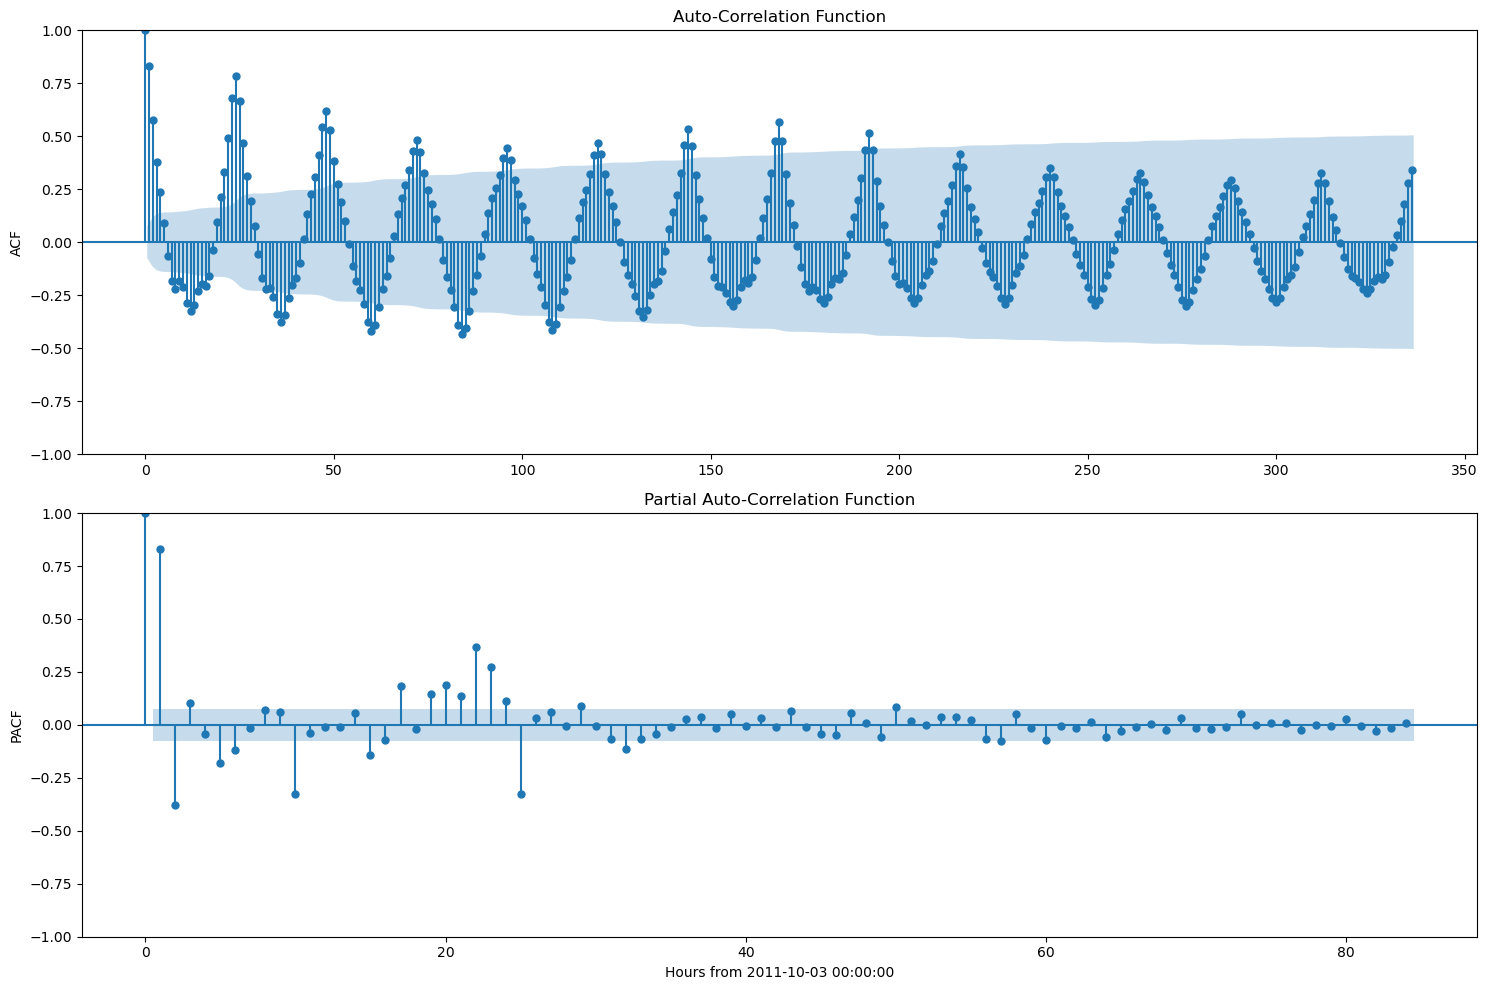

In [34]:
# Make tmp df
tmp = df.copy()

# Focus only on week 40
tmp["year"] = tmp.index.isocalendar().year
tmp["weekofyear"] = tmp.index.isocalendar().week
tmp = tmp[tmp["weekofyear"].isin([40, 41])]

# Plot acf and pacf from statsmodel
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
axes = axes.flatten()
plot_acf(tmp["count"], lags=24 * 14, alpha=0.05, ax=axes[0], title="Auto-Correlation Function")
plot_pacf(tmp["count"], lags=24 * 7 // 2, alpha=0.05, ax=axes[1], title="Partial Auto-Correlation Function")
axes[0].set_ylabel("ACF")
axes[1].set_ylabel("PACF")
axes[1].set_xlabel(f"Hours from {tmp.index[0]}")
plt.tight_layout()
plt.show()

From the above plots we see that:
- ACF exhibits a significant drop after 5 hours, so we can consider MA components of this length. Moreover, we can see the periodicity both at 24 and 168 hours, namely 1 day and 1 week
- PACF exhibits a cutoff after the second hour, se we can consider 2 AR components

Let's add the lags and moving averages features.

In [42]:
# Lag features
autoregressive_lags = [0, 1, 2]
seasonal_lags = [24, 168]
for slag in seasonal_lags:
    for arlag in autoregressive_lags:
        df[f"count_lag_{slag}_{arlag}"] = df["count"].shift(slag+arlag)
        df[f"registered_lag_{slag}_{arlag}"] = df["registered"].shift(slag+arlag)
        df[f"casual_lag_{slag}_{arlag}"] = df["casual"].shift(slag+arlag)

# Moving average features
df["count_ma"] = df["count_lag_24_0"].rolling(5).mean()
df["registered_ma"] = df["registered_lag_24_0"].rolling(5).mean()
df["casual_ma"] = df["casual_lag_24_0"].rolling(5).mean()

# Print tail of df_train
df.iloc[10881:10886]

,atemp,casual,count,holiday,humidity,registered,season,temp,weather,windspeed,...,casual_lag_168_0,count_lag_168_1,registered_lag_168_1,casual_lag_168_1,count_lag_168_2,registered_lag_168_2,casual_lag_168_2,count_ma,registered_ma,casual_ma
datetime,,,,,,,,,,,,,,,,,,,,,
2012-12-19 19:00:00,19.695,7.0,336.0,0,50,329.0,4,15.58,1,26.0027,...,18.0,540.0,515.0,25.0,561.0,540.0,21.0,411.8,384.0,27.8
2012-12-19 20:00:00,17.425,10.0,241.0,0,57,231.0,4,14.76,1,15.0013,...,25.0,402.0,384.0,18.0,540.0,515.0,25.0,416.2,393.2,23.0
2012-12-19 21:00:00,15.910,4.0,168.0,0,61,164.0,4,13.94,1,15.0013,...,16.0,268.0,243.0,25.0,402.0,384.0,18.0,377.2,360.4,16.8
2012-12-19 22:00:00,17.425,12.0,129.0,0,61,117.0,4,13.94,1,6.0032,...,4.0,202.0,186.0,16.0,268.0,243.0,25.0,289.2,279.2,10.0
2012-12-19 23:00:00,16.665,4.0,88.0,0,66,84.0,4,13.12,1,8.9981,...,3.0,122.0,118.0,4.0,202.0,186.0,16.0,200.4,192.8,7.6


Finally, let's bin atemp, humidity and windspeed

In [43]:
# Add bin columns
df["binned_atemp"] = pd.qcut(x=tmp["atemp"], q=5)
df["binned_windspeed"] = pd.qcut(x=tmp["windspeed"], q=5)
df["binned_humidity"] = pd.qcut(x=tmp["humidity"], q=5)

In [ ]:
# Let's drop useless columns
df.drop(["workingday", "temp", "atemp", "humidity", "windspeed"])

# Split train, val and test
df_train = df.iloc[:10886].copy()
df_test = df.iloc[10886:].copy()

# 3. Model